
* Class Neural_Network keeps weights and processes feedforward and backpropagation algorithms through its weights.
* Function learn(net, rate, steps, data) gives learned neural network and shows progress bar while network is being learned.
* createUI() creates user interface to vary parameters also shows an approximated function and learned network

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.special import expit # sigmoid funciton
%matplotlib inline

In [2]:
# Neural Network class
class Neural_Network(object):
    def __init__(self, inputDim, hiddenDim, outputDim):
        #Define HyperParameters
        self.inputLayerSize = inputDim
        self.hiddenLayerSize = hiddenDim
        self.outputLayerSize = outputDim
        
        # Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize, \
                                  self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize, \
                                  self.outputLayerSize)

    def forward(self, X):
        #Propagate inputs through network
        self.a1 = X
        self.z2 = np.dot(self.a1, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        self.a3 = self.sigmoid(self.z3)
        return self.a3 # yHat
    
    def sigmoid(self, z):
        #Apply sigmoid activation function
        return expit(z)        
        
    def sigmoidPrime(self, z):
        #Derivative of Sigmoid Function
        #return np.exp(-z)/((1+np.exp(-z))**2)
        return np.exp(-z)*np.square(expit(z))
        
    def costFunction(self, X, y):
        #Calculate cost for given X,y, use wheights already stored in class
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
    
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W1 and W2
        self.yHat = self.forward(X)
        #print('yHat',self.yHat)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)
        #print('delta2',delta2)
        
        return dJdW1, dJdW2
    
# Creating new instance of Neural Network class
def CreateNN(inputDim, hiddenDim, outputDim):
     return Neural_Network(inputDim, hiddenDim, outputDim)

In [9]:
# Distribution can be: 'logistic', 'normal', 'uniform'
def generateData(func, linspace, bias, numExamples, distribution='logistic'):
    """
    generateData(func, linspace, bias, numExamples, distribution='logistic'):
    
        Data generating function. Generates points with `logistic`, `normal` and `uniform` distributions
        along x axis and randomly shifts function output by uniform distribution with bias coeffecient
    """
    if distribution == 'logistic':
        loc = np.mean(linspace)
        scale = (linspace[-1]-linspace[0])/15
        x = np.random.logistic(loc, scale, numExamples)
    elif distribution == 'normal':
        mu = np.mean(linspace)
        sigma = (linspace[-1] - linspace[0])/2*0.3
        x = np.random.normal(mu, sigma, numExamples)
    elif distribution == 'uniform':
        x = np.random.uniform(linspace[0], linspace[-1], numExamples)
    else: # wrong distribution has been specified
        return linspace, linspace
    
    x = np.clip(x, linspace[0], linspace[-1])
    y = [func(dx) for dx in x]
    ysigma = np.max(y) - np.min(y)
    y = np.array([dy + (np.random.rand(1)[0] - 0.5)*bias*ysigma for dy in y])
    return x, y


def f(x): # f(x) is a function to be approximated
    #return np.sign(x)*np.sqrt(abs(x))
    return 1/(np.square(x)+1)
def fNorm(y): # fNorm(y): normalizes data returned by f(x) function in [0, 1] range
    #return y/4 + 0.5
    return y/2 # max of 1/np.cos(x) in range [-Pi/3, Pi/3]
def fRestore(y): # fRestore(y): restores normalized data to its original value
    #return (y - 0.5)*4
    return y*2
def polynomize(X, degree): # polynomize(X, degree): adds polynomial term from first value
    for i in range(1, degree):
        X = np.insert(X, i, 0, axis=1)
        X[:, i] = np.power(X[:, 0], i+1)
    return X

# returns tuple of data, such that:
#  data = ((X, Y), (Xtrain, Ytrain), (Xtest, Ytest))
def getDataParts(linspace, polyDegree=4, bias=0.125, numExamples=100, trainTestDiv=0.7, distribution='logistic'):
    # trainTestDiv=0.7 means that 70% train data and 30% for test data
    X, Y = generateData(f, linspace, bias, numExamples, distribution)
    # Reformat data shapes
    X = X[np.newaxis].T
    Y = fNorm(Y[np.newaxis].T) # Normalizing function data

    # Add polinomial terms to input data
    X = polynomize(X, polyDegree)

    # Add train/test division of data
    Xtrain = X[:int(X.shape[0]*trainTestDiv)]
    Ytrain = Y[:int(Y.shape[0]*trainTestDiv)]

    Xtest = X[int(X.shape[0]*trainTestDiv):]
    Ytest = Y[int(Y.shape[0]*trainTestDiv):]

    return (X, Y), (Xtrain, Ytrain), (Xtest, Ytest)

def displayLearnedNN(NNinstance, data, space, polyDegree, drawTrainData=True, drawTestData=True):
    (X, Y), (Xtrain, Ytrain), (Xtest, Ytest) = data
    nnX = polynomize(space[np.newaxis].T, polyDegree)
    nnY = NNinstance.forward(nnX)

    plt.figure(0, figsize=(12,10))
    plt.plot(space, f(space), label='Approximated function')
    plt.plot(space, fRestore(nnY), label='Neural Network approximation')
    if drawTrainData:
        plt.plot(Xtrain[:,0], fRestore(Ytrain), '.', color='red', label='Train data points')
    if drawTestData:
        plt.plot(Xtest[:,0], fRestore(Ytest), '.', color='blue', label='Test data points')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    # Place a legend to the right of this smaller subplot.
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
def displayLearningCosts(costData):
    costDataTotal, costDataTrain, costDataTest = costData
    plt.figure(0, figsize=(14,10))
    plt.plot(costDataTotal[0], costDataTotal[1], color='black', label="Total")
    plt.plot(costDataTrain[0], costDataTrain[1], color='red',   label="Train")
    plt.plot(costDataTest[0],  costDataTest[1],  color='blue',  label="Test")
    plt.xlabel('Step')
    plt.ylabel('Cost')
    # Place a legend to the right of this smaller subplot.
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [4]:
# data = ((X, Y), (Xtrain, Ytrain), (Xtest, Ytest))
def learn(net, rate, steps, data):
    # utility functions
    def scalarCost(cost):
        return np.sum(cost)
    def signsToVectors(mat):
        """
        Accepts array of sign changes where 1 and -1 determs whether or not sign
        has been changed. For -1 it is changed state and for 1 it is unchanged.
        Replaces elements with 1 and -1 to [1, 0] and [0, 1] vectors accordingly.
        Example:
            [1,-1,1] -> [[1,0],[0,1],[1,0]]
        """
        # Formula of this mapping is: mat = mat*b + c
        # Multiplication is elementwise
        b = np.empty(mat.shape + (2,))
        c = np.empty(mat.shape + (2,))
        # Initalizing range mapping matricies
        b[..., 0] = 0.5
        b[..., 1] = -0.5
        c[..., :] = 0.5
        mat = mat.reshape(mat.shape + (1,))
        mat = mat*b + c
        return mat
    # ==========================================================
    # learn() body:
    # ==========================================================
    (X, Y), (Xtrain, Ytrain), (Xtest, Ytest) = data
    
    progressBar = widgets.FloatProgress(
        value=0, min=0, max=steps,
        step=1, description='Learning:', bar_style='success'
    )
    display(progressBar)
    
    costDataTotal = np.empty((2, steps))
    costDataTrain = np.empty((2, steps))
    costDataTest = np.empty((2, steps))
    # last weights
    prevW1 = np.copy(net.W1) 
    prevW2 = np.copy(net.W2)
    # rate of learning for every weight
    rateW1 = np.ones(net.W1.shape)*rate
    rateW2 = np.ones(net.W2.shape)*rate
    # last signs of derivatives of J with respect to weights
    prevdJdW1 = np.zeros(net.W1.shape)
    prevdJdW2 = np.zeros(net.W2.shape)

    for i in range(steps):
        dJdW1, dJdW2 = net.costFunctionPrime(Xtrain, Ytrain)
        # Dynamiclly choosing learning rate
        if i > 0: # We have previous values
            # generating of sign differences between current and previous
            # weights, represented by vectors [1,0] and [0,1]
            svW1 = signsToVectors(np.sign(prevdJdW1 * dJdW1))
            svW2 = signsToVectors(np.sign(prevdJdW2 * dJdW2))
            
            # Evaluated weights matrix
            # Contains pairs of [W - dJdW, (prevW+W)/2] to be
            # multiplied on sign differences and summed together
            
            # === Rate changes
            eR1o = rateW1 # old term
            eR1n = rateW1*0.5 # new term
            eR1 = np.concatenate((eR1o[...,np.newaxis], eR1n[...,np.newaxis]),axis=2)
            
            eR2o = rateW2 # old term
            eR2n = rateW2*0.5 # new term
            eR2 = np.concatenate((eR2o[...,np.newaxis], eR2n[...,np.newaxis]),axis=2)
            
            rateW1 = np.sum(svW1*eR1, axis=2)
            rateW2 = np.sum(svW2*eR2, axis=2)
            # ===
            
            
            # === Weights changes
            # np.concatenate((a[...,np.newaxis],b[...,np.newaxis]),axis=2)
            eW1o = net.W1 - rateW1*dJdW1 # old term
            eW1n = (net.W1 + prevW1)*0.5 # new term
            eW1 = np.concatenate((eW1o[...,np.newaxis], eW1n[...,np.newaxis]),axis=2)
            
            eW2o = net.W2 - rateW2*dJdW2 # derivative term
            eW2n = (net.W2 + prevW2)*0.5 # average term
            eW2 = np.concatenate((eW2o[...,np.newaxis], eW2n[...,np.newaxis]),axis=2)
            # === //
            
            # Save last weights 
            prevW1 = net.W1
            prevW2 = net.W2
            
            # Compute final transformation
            # svW1*eW1 contains either [0, (prevW+W)/2] if sign has been changed
            # or [W -dJdW, 0] if sign hasn't been changed
            net.W1 = np.sum(svW1*eW1, axis=2) # sum last axis
            net.W2 = np.sum(svW2*eW2, axis=2)
        else:
            # Save last weights 
            prevW1 = net.W1
            prevW2 = net.W2
            
            net.W1 = net.W1 - rateW1*dJdW1 # learning_rate has been
            net.W2 = net.W2 - rateW2*dJdW2 # removed
        
        # save previous derivatives
        prevdJdW1 = dJdW1
        prevdJdW2 = dJdW2
        
        costDataTotal[0][i] = i
        costDataTotal[1][i] = scalarCost(net.costFunction(X,Y))
        
        costDataTrain[0][i] = i
        costDataTrain[1][i] = scalarCost(net.costFunction(Xtrain,Ytrain))
        
        costDataTest[0][i] = i
        costDataTest[1][i] = scalarCost(net.costFunction(Xtest,Ytest))
        
        # end of iteration 
        progressBar.value = i
        
    progressBar.close()
    
    return net, (costDataTotal, costDataTrain, costDataTest)

In [10]:
def createUI():
    # Unchangable defaults
    initRate = 0.025
    #space = np.linspace(-3, 3, 100)
    space = np.linspace(-np.pi/3, np.pi/3, 100)

    # UI changable parameters
    distribution='uniform'
    drawTrainPoints = True
    drawTestPoints = True
    bias = 0.1
    numExamples=250
    trainTestDiv=0.7
    steps = 3000
    polyDegree = 2
    hiddenNeurons = 25
    
    # Assignment cache
    cachePolyDegree = polyDegree
    
    # Common variables for wrappers
    NNinstance = None
    costData = None
    data = None
    
    def dataChangedEventWrapper(change):
        nonlocal polyDegree
        nonlocal distribution
        nonlocal drawTrainPoints
        nonlocal drawTestPoints
        nonlocal bias
        nonlocal numExamples
        nonlocal trainTestDiv
        nonlocal steps
        nonlocal polyDegree
        nonlocal hiddenNeurons
        nonlocal data
        
        if change['owner'] == toggles:
            distribution = change['new']
        elif change['owner'] == checkTrainPoints:
            drawTrainPoints = change['new']
        elif change['owner'] == checkTestPoints:
            drawTestPoints = change['new']
        elif change['owner'] == biasUI:
            bias = change['new']
        elif change['owner'] == numExamplesUI:
            numExamples = change['new']
        elif change['owner'] == trainTestDivUI:
            trainTestDiv = change['new']
        # learning specific data
        elif change['owner'] == stepsUI:
            steps = change['new']
            return
        elif change['owner'] == degreeUI:
            #polyDegree = change['new']
            cachePolyDegree = change['new']
            return
        elif change['owner'] == hiddenNeuronsUI:
            hiddenNeurons = change['new']
            return
            
        data = getDataParts(space, polyDegree=polyDegree,
                            bias=bias, numExamples=numExamples,
                            trainTestDiv=trainTestDiv, distribution=distribution)
        drawEventWrapper()
        
    def learnEventWrapper(b):
        nonlocal polyDegree
        nonlocal hiddenNeurons
        nonlocal initRate
        nonlocal steps
        nonlocal data
        nonlocal costData
        nonlocal NNinstance
        
        learnButton.disabled=True

        if data is None:
            dataChangedEventWrapper({'owner':None})
            return
        
        # Delayed assignment
        if polyDegree != cachePolyDegree:
            polyDegree = cachePolyDegree
            
        # run learn function
        NNinstance, costData = learn(CreateNN(polyDegree, hiddenNeurons, 1), initRate, steps, data)
        drawEventWrapper()
        
        learnButton.disabled=False
    
    def drawEventWrapper():
        nonlocal space
        nonlocal data
        nonlocal costData
        nonlocal polyDegree
        nonlocal NNinstance
        
        if NNinstance is None:
            learnEventWrapper(None)
            return
        
        clear_output()
        print('data: \t\t', data[0][0].shape[0],
              ' samples','\ntrain / test:\t',
              data[1][0].shape[0], '/', data[2][0].shape[0])
        
        displayLearnedNN(NNinstance, data, space, polyDegree, drawTrainPoints, drawTestPoints)
        displayLearningCosts(costData)
        
    # Learn button
    learnButton = widgets.Button(description="Learn",
                                 layout=widgets.Layout(margin='0px 0px 0px 90px'))
    learnButton.on_click(learnEventWrapper)
    
    # checkboxes
    checkTrainPoints = widgets.Checkbox(value=True)
    checkTestPoints = widgets.Checkbox(value=True)

    # Points distribution chooser
    togglesLabel = widgets.Label('Points distribution:')
    toggles = widgets.ToggleButtons(value=distribution,
                                    options=['logistic', 'normal', 'uniform'],
                                    layout=widgets.Layout(width='auto'))

    # inital parameters
    biasUI = widgets.BoundedFloatText(value=bias, min=0, max=1, step=0.0625, description='Bias:')
    numExamplesUI = widgets.BoundedIntText(value=numExamples, min=10, max=1000, step=10, description='Examples:')
    trainTestDivUI = widgets.FloatSlider(value=trainTestDiv, min=0, max=1.0, step=0.1, description='Train/Test:',
                                         continuous_update=False)
    stepsUI = widgets.BoundedIntText(value=steps, min=1, max=10000, step=10, description='Steps:')
    degreeUI = widgets.BoundedIntText(value=polyDegree, min=1, max=6, step=1, description='Degree:')
    hiddenNeuronsUI = widgets.BoundedIntText(value=hiddenNeurons, min=1, max=50, step=1, description='Hidden neurons:')

    # Layout creating
    box_layout = widgets.Layout(display='flex', flex_flow='column',
                                justify_content='space-between',
                                align_items='stretch', width='100%')

    items = []
    items.append(widgets.HBox([togglesLabel, toggles, learnButton]))
    items.append(widgets.HBox([widgets.VBox([biasUI, numExamplesUI, trainTestDivUI]),
                               widgets.VBox([stepsUI, degreeUI, hiddenNeuronsUI])]))
    items.append(widgets.HBox([widgets.HBox([widgets.Label('Train points:'), checkTrainPoints]),
                               widgets.HBox([widgets.Label('Test points:'), checkTestPoints])]))

    # Function connecting
    checkTrainPoints.observe(dataChangedEventWrapper, names='value')
    checkTestPoints.observe(dataChangedEventWrapper, names='value')
    toggles.observe(dataChangedEventWrapper, names='value')
    biasUI.observe(dataChangedEventWrapper, names='value')
    numExamplesUI.observe(dataChangedEventWrapper, names='value')
    trainTestDivUI.observe(dataChangedEventWrapper, names='value')
    stepsUI.observe(dataChangedEventWrapper, names='value')
    degreeUI.observe(dataChangedEventWrapper, names='value')
    hiddenNeuronsUI.observe(dataChangedEventWrapper, names='value')


    # Complete layout
    box = widgets.Box(children=items, layout=box_layout)

    # display UI
    display(box)
    
    # Generate inital data
    dataChangedEventWrapper({'owner':None})

data: 		 250  samples 
train / test:	 175 / 75


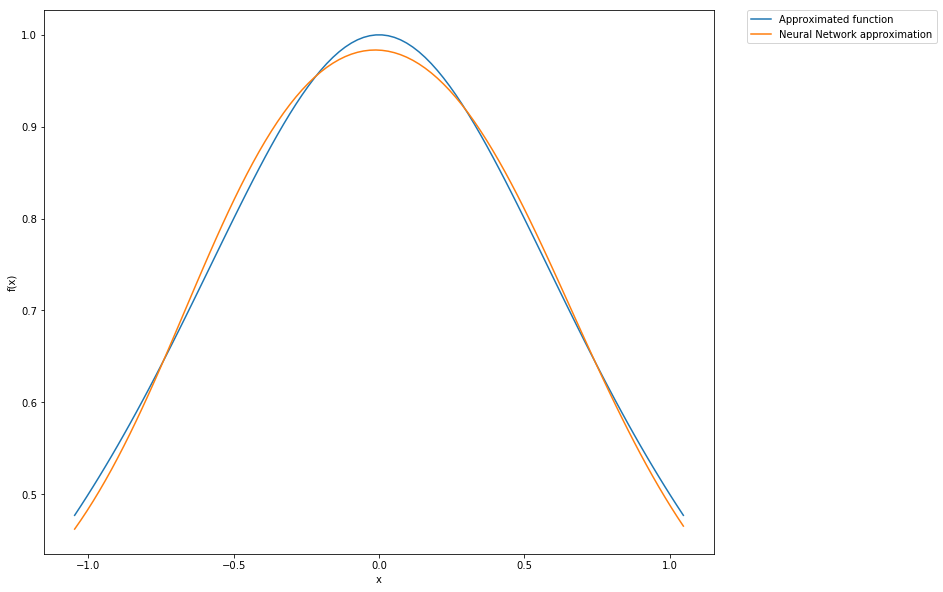

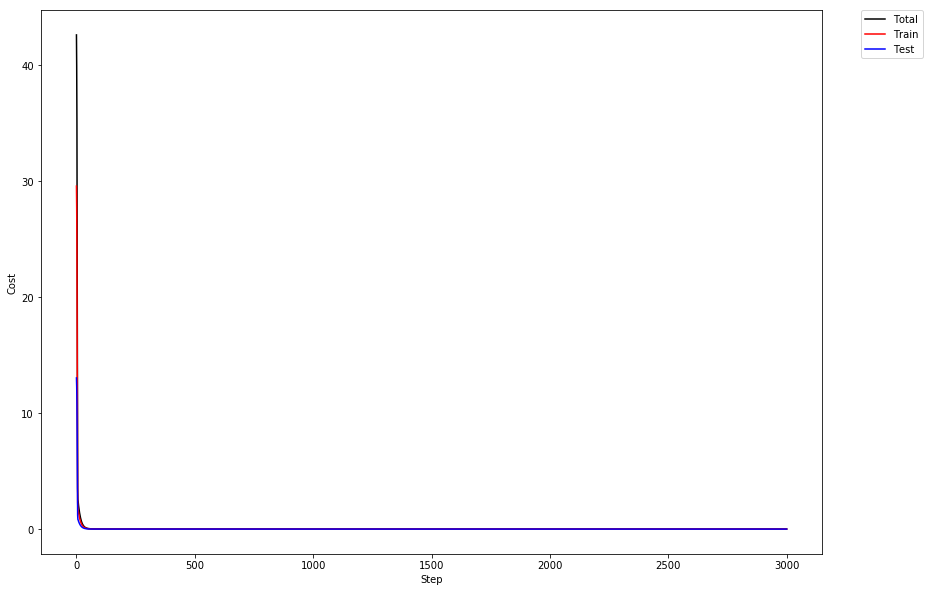

In [11]:
createUI()

In [3]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")